In [ ]:
!pip install monai
!pip install torch
!pip install torch-vision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
# Standard output is '/device:GPU:0'

'/device:GPU:0'

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    NormalizeIntensityd,
    Orientationd,
    ScaleIntensityRanged,
    RandCropByPosNegLabeld,
    CropForegroundd,
    RandSpatialCropd,
    Resized,
    ScaleIntensityd,
    RandRotated,
    RandZoomd,
    RandGaussianNoised,
    Flipd,
    RandAffined,
    CropForegroundd)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.data import Dataset, DataLoader
from monai.utils import first
import torch
import matplotlib.pyplot as plt
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

In [ ]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [ ]:
#https://discuss.pytorch.org/t/unable-to-find-a-valid-cudnn-algorithm-to-run-convolution/78724/2
torch.backends.cudnn.enabled = False

In [ ]:
in_dir = '/content/'
data_dir = '/content/'

In [ ]:
train_images = sorted(glob(os.path.join(data_dir, 'train images', '*.nii.gz')))
train_labels = sorted(glob(os.path.join(data_dir, 'train masks', '*.nii.gz')))
print(train_images)
val_images = sorted(glob(os.path.join(data_dir, 'validation images', '*.nii.gz')))
val_labels = sorted(glob(os.path.join(data_dir, 'validation masks', '*.nii.gz')))

train_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(train_images, train_labels)]
print(train_files)
val_files = [{"image": image_name, 'label': label_name} for image_name, label_name in zip(val_images, val_labels)]

['/content/train images/patient_001_0.nii.gz', '/content/train images/patient_002_0.nii.gz', '/content/train images/patient_004_0.nii.gz', '/content/train images/patient_005_0.nii.gz', '/content/train images/patient_006_0.nii.gz', '/content/train images/patient_007_0.nii.gz', '/content/train images/patient_009_0.nii.gz', '/content/train images/patient_010_0.nii.gz', '/content/train images/patient_011_0.nii.gz', '/content/train images/patient_013_0.nii.gz', '/content/train images/patient_014_0.nii.gz', '/content/train images/patient_015_0.nii.gz', '/content/train images/patient_016_0.nii.gz', '/content/train images/patient_017_0.nii.gz', '/content/train images/patient_018_0.nii.gz', '/content/train images/patient_018_1.nii.gz', '/content/train images/patient_019_0.nii.gz', '/content/train images/patient_020_0.nii.gz', '/content/train images/patient_021_0.nii.gz', '/content/train images/patient_022_0.nii.gz', '/content/train images/patient_023_0.nii.gz', '/content/train images/patient_02

In [ ]:
# load the images
# do any transforms
# need to convert them into troch tensors

orig_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        
        ToTensord(keys=['image', 'label'])
    ]
)

train_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        #EnsureChannelFirstd(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        #NormalizeIntensityd(keys=['image', 'label'], nonzero=True), 
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys='image', a_min=-400, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=10), 
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=10.0),
        RandGaussianNoised(keys='image', prob=0.5),
        Resized(keys=['image', 'label'], spatial_size=[512,512,32]),
        ToTensord(keys=['image', 'label'])
    ]
)


val_transforms = Compose(

    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        ScaleIntensityRanged(keys='image', a_min=-400, a_max=1000, b_min=0.0, b_max=1.0, clip=True),
        ToTensord(keys=['image', 'label'])
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
orig_ds = Dataset(data=train_files, transform=orig_transforms)
orig_loader = DataLoader(orig_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [ ]:
test_patient = first(train_loader)
orig_patient = first(orig_loader)

In [ ]:
print(torch.min(test_patient['image']))
print(torch.max(test_patient['image']))

tensor(0.2081)
tensor(0.9912)


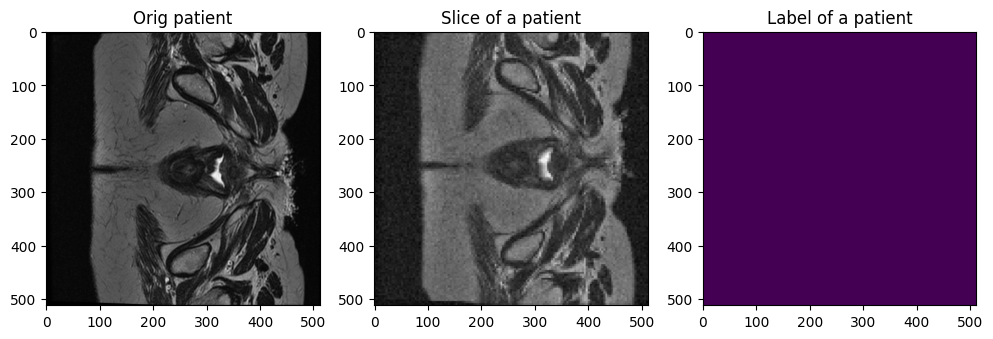

In [ ]:
plt.figure('test', (12, 6))

plt.subplot(1, 3, 1)
plt.title('Orig patient')
plt.imshow(orig_patient['image'][0, 0, :, :, 6], cmap= "gray")

plt.subplot(1, 3, 2)
plt.title('Slice of a patient')
plt.imshow(test_patient['image'][0, 0, : ,: ,6], cmap= "gray")

plt.subplot(1,3,3)
plt.title('Label of a patient')
plt.imshow(test_patient['label'][0, 0, : ,: ,6])
plt.show()

In [ ]:
def prepare(in_dir, pixdim=(1.5, 1.5, 2.0), a_min=-400, a_max=1000, spatial_size=[512, 512,32], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you 
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "train images", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "train masks", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "validation images", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "validation masks", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            ScaleIntensityRanged(keys=["seg"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=False), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            
            RandAffined(keys=["vol", "seg"], prob=0.5, translate_range=10), 
            RandRotated(keys=["vol", "seg"], prob=0.5, range_x=10.0),
            RandGaussianNoised(keys='vol', prob=0.5),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True),
            ScaleIntensityRanged(keys=["seg"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=False),  
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [ ]:
patients = prepare(in_dir)
patients

(<monai.data.dataloader.DataLoader at 0x7fadc4639390>,
 <monai.data.dataloader.DataLoader at 0x7fadc4639270>)

In [ ]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

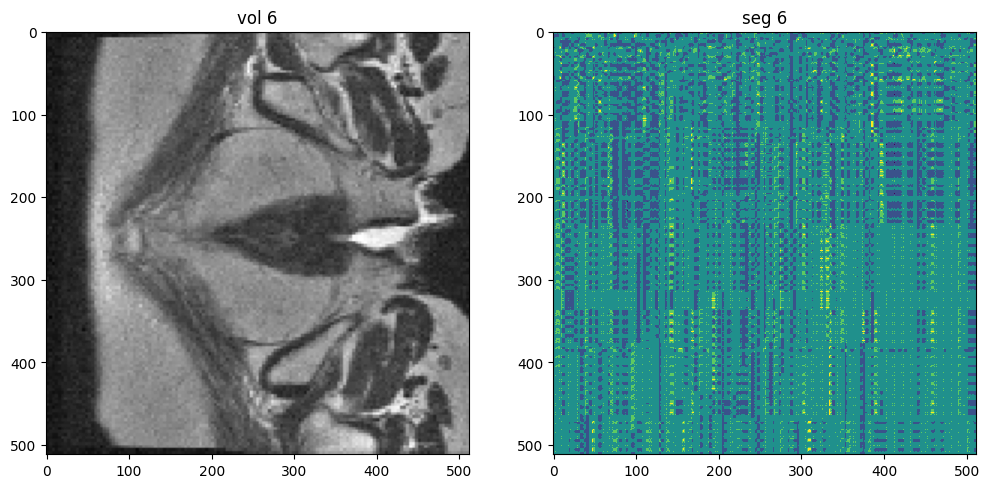

In [ ]:
show_patient(patients, 6)

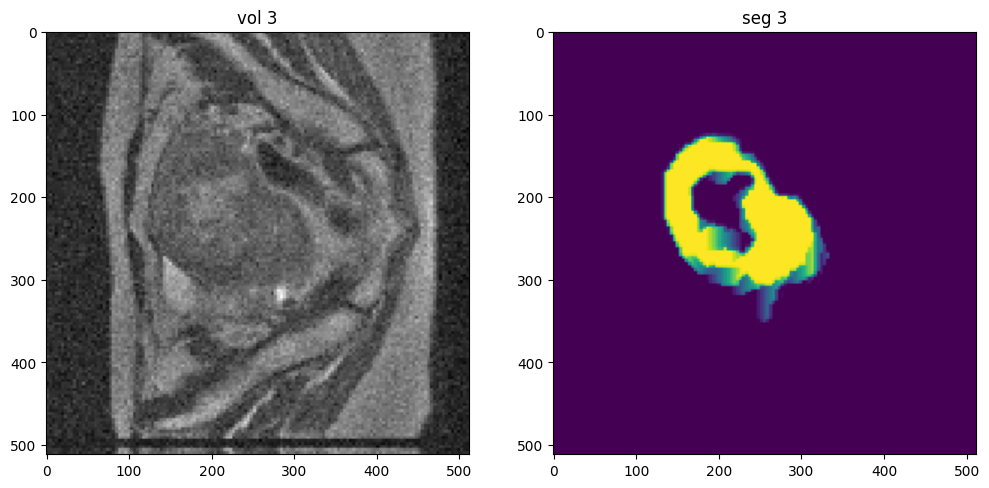

In [ ]:
show_patient(patients, 3)

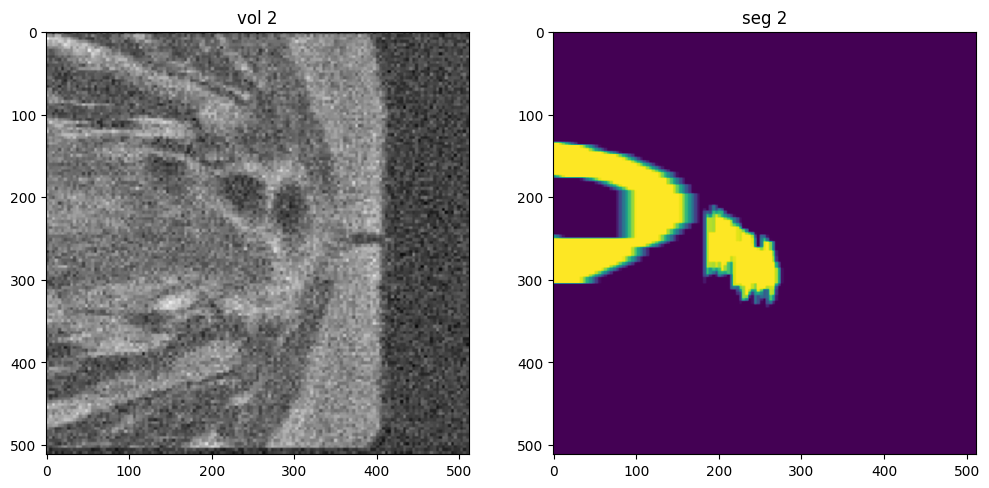

In [ ]:
show_patient(patients, 2)

In [ ]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [ ]:
def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

In [ ]:
def train(model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [ ]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.
    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference

In [ ]:
device = torch.device("cuda:0")
#torch.cuda.device(0)
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:219: FutureWarning: monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=3e-5, amsgrad=True)

In [ ]:
data_in = prepare(in_dir, cache=True)

Loading dataset: 100%|██████████| 16/16 [00:35<00:00,  2.23s/it]


In [ ]:
model_dir = '/content/results' 

In [ ]:
#model, data_in, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")
train(model, data_in, loss_function, optimizer, 50, model_dir)

----------
epoch 1/50


/usr/local/lib/python3.10/dist-packages/monai/losses/dice.py:144: UserWarning: single channel prediction, `to_onehot_y=True` ignored.
  warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")


1/44, Train_loss: 0.2228
Train_dice: 0.7772
2/44, Train_loss: 0.2231
Train_dice: 0.7769
3/44, Train_loss: 0.2215
Train_dice: 0.7785
4/44, Train_loss: 0.2221
Train_dice: 0.7779
5/44, Train_loss: 0.2228
Train_dice: 0.7772
6/44, Train_loss: 0.2227
Train_dice: 0.7773
7/44, Train_loss: 0.2226
Train_dice: 0.7774
8/44, Train_loss: 0.2225
Train_dice: 0.7775
9/44, Train_loss: 0.2223
Train_dice: 0.7777
10/44, Train_loss: 0.2224
Train_dice: 0.7776
11/44, Train_loss: 0.2217
Train_dice: 0.7783
12/44, Train_loss: 0.2216
Train_dice: 0.7784
13/44, Train_loss: 0.2218
Train_dice: 0.7782
14/44, Train_loss: 0.2219
Train_dice: 0.7781
15/44, Train_loss: 0.2212
Train_dice: 0.7788
16/44, Train_loss: 0.2198
Train_dice: 0.7802
17/44, Train_loss: 0.2213
Train_dice: 0.7787
18/44, Train_loss: 0.2214
Train_dice: 0.7786
19/44, Train_loss: 0.2204
Train_dice: 0.7796
20/44, Train_loss: 0.2206
Train_dice: 0.7794
21/44, Train_loss: 0.2195
Train_dice: 0.7805
22/44, Train_loss: 0.2202
Train_dice: 0.7798
23/44, Train_loss: 

In [ ]:
model_dir = '/content/results'

In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

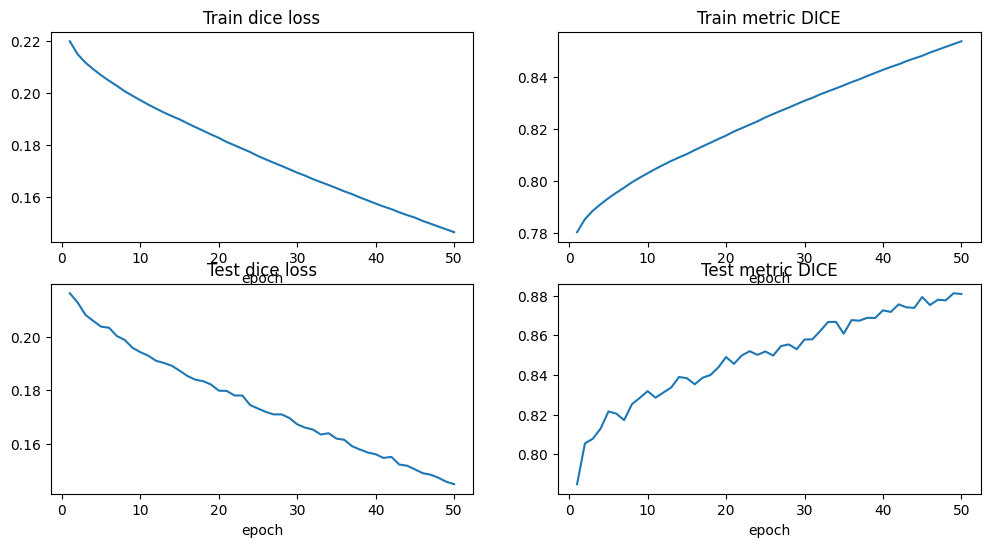

In [ ]:
plt.figure("Results", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()